In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
test2 = pd.read_csv('input/test.csv')
titanic = pd.concat([train, test], sort=False)
len_train = train.shape[0]

In [3]:
titanic.dtypes.sort_values()

PassengerId      int64
Pclass           int64
SibSp            int64
Parch            int64
Survived       float64
Age            float64
Fare           float64
Name            object
Sex             object
Ticket          object
Cabin           object
Embarked        object
dtype: object

In [4]:
titanic.select_dtypes(include='int').head()

,PassengerId,Pclass,SibSp,Parch
0,1,3,1,0
1,2,1,1,0
2,3,3,0,0
3,4,1,1,0
4,5,3,0,0


In [5]:
titanic.select_dtypes(include='float').head()

,Survived,Age,Fare
0,0.0,22.0,7.2500
1,1.0,38.0,71.2833
2,1.0,26.0,7.9250
3,1.0,35.0,53.1000
4,0.0,35.0,8.0500


处理缺失值

In [6]:
titanic.isnull().sum()[titanic.isnull().sum()>0]

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [7]:
train.Fare = train.Fare.fillna(train.Fare.mean())
test.Fare = test.Fare.fillna(train.Fare.mean())

In [8]:
train.Cabin = train.Cabin.fillna('unknow')
test.Cabin = test.Cabin.fillna('unknow')

In [9]:
train.Embarked=train.Embarked.fillna(train.Embarked.mode()[0])
test.Embarked=test.Embarked.fillna(train.Embarked.mode()[0])
#mode方法为求众数（频数最高的值）

In [10]:
a = train.Name[0]

In [11]:
a

'Braund, Mr. Owen Harris'

In [12]:
a.split('.')[0].split(',')[1].strip()

'Mr'

In [13]:
train['title'] = train.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())
test['title'] = test.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())

In [14]:
train.title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Jonkheer          1
Lady              1
Ms                1
Capt              1
the Countess      1
Mme               1
Don               1
Sir               1
Name: title, dtype: int64

In [15]:
newtitles={
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir":         "Royalty",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "the Countess":"Royalty",
    "Dona":        "Royalty",
    "Mme":         "Mrs",
    "Mlle":        "Miss",
    "Ms":          "Mrs",
    "Mr":          "Mr",
    "Mrs":         "Mrs",
    "Miss":        "Miss",
    "Master":      "Master",
    "Lady":        "Royalty"
}

In [16]:
train['title'] = train.title.map(newtitles)
test['title'] = test.title.map(newtitles)

In [17]:
train.groupby(['title', 'Sex']).Age.mean()

title    Sex   
Master   male       4.574167
Miss     female    21.804054
Mr       male      32.368090
Mrs      female    35.718182
Officer  female    49.000000
         male      46.562500
Royalty  female    40.500000
         male      42.333333
Name: Age, dtype: float64

In [18]:
def newage(cols):
    title=cols[0]
    Sex=cols[1]
    Age=cols[2]
    if pd.isnull(Age):
        if title=='Master' and Sex=='male':
            return 4.57
        elif title=='Miss' and Sex=='female':
            return 21.8
        elif title=='Mr' and Sex=='male':
            return 32.37
        elif title=='Mrs' and Sex=='female':
            return 35.72
        elif title=='Officer' and Sex=='female':
            return 49
        elif title=='Officer' and Sex=='male':
            return 46.56
        elif title=='Royalty' and Sex=='female':
            return 40.5
        elif title=='Royalty' and Sex=='male':
            return 42.33
    else:
        return Age

In [19]:
train.Age = train[['title', 'Sex', 'Age']].apply(newage, axis=1)
test.Age = test[['title', 'Sex', 'Age']].apply(newage, axis=1)

数据探索

In [20]:
import warnings
warnings.filterwarnings(action="ignore")

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

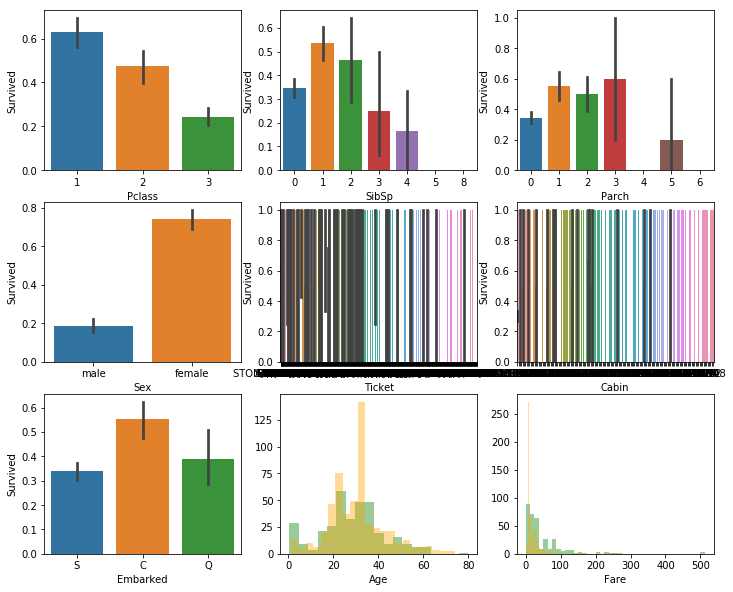

In [22]:
plt.figure(figsize=[12, 10])
plt.subplot(3,3,1)
sns.barplot('Pclass', 'Survived', data=train)
plt.subplot(3,3,2)
sns.barplot('SibSp', 'Survived', data=train)
plt.subplot(3,3,3)
sns.barplot('Parch', 'Survived', data=train)
plt.subplot(3,3,4)
sns.barplot('Sex', 'Survived', data=train)
plt.subplot(3,3,5)
sns.barplot('Ticket', 'Survived', data=train)
plt.subplot(3,3,6)
sns.barplot('Cabin', 'Survived', data=train)
plt.subplot(3,3,7)
sns.barplot('Embarked', 'Survived', data=train)
plt.subplot(3,3,8)
sns.distplot(train[train.Survived==1].Age, color='green', kde=False)
sns.distplot(train[train.Survived==0].Age, color='orange', kde=False)
plt.subplot(3,3,9)
sns.distplot(train[train.Survived==1].Fare, color='green', kde=False)
sns.distplot(train[train.Survived==0].Fare, color='orange', kde=False)

特征工程

In [23]:
train['Relatives'] = train.SibSp + train.Parch
test['Relatives'] = test.SibSp + test.Parch

In [24]:
train['Ticket2'] = train.Ticket.apply(lambda x: len(x))
test['Ticket2'] = test.Ticket.apply(lambda x: len(x))

In [25]:
train['Cabin2'] = train.Ticket.apply(lambda x: len(x))
test['Cabin2'] = test.Ticket.apply(lambda x: len(x))

In [26]:
train['Name2'] = train.Name.apply(lambda x: x.split(',')[0].strip())
test['Name2'] = test.Name.apply(lambda x: x.split(',')[0].strip())

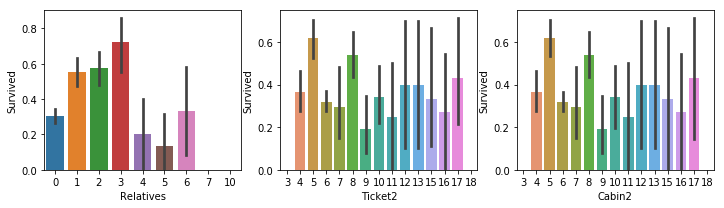

In [27]:
plt.figure(figsize=[12, 10])
plt.subplot(3,3,1)
sns.barplot('Relatives', 'Survived', data=train)
plt.subplot(3,3,2)
sns.barplot('Ticket2', 'Survived', data=train)
plt.subplot(3,3,3)
sns.barplot('Cabin2', 'Survived', data=train)

数据准备

In [28]:
train.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [29]:
titanic = pd.concat([train, test], sort=False)

In [30]:
titanic=pd.get_dummies(titanic)

In [31]:
train = titanic[:len_train]
test = titanic[len_train:]

In [32]:
train.Survived.dtype

dtype('float64')

In [33]:
train.Survived = train.Survived.astype('int')

In [34]:
train.Survived.dtype

dtype('int64')

In [35]:
y = train.Survived
X = train.drop('Survived', axis=1)

In [36]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# 3 建模讯模
my_pipeline = make_pipeline(Imputer(), XGBRegressor(n_estimators=1000, learning_rate=0.05))
my_pipeline.fit(train_X, train_y)
# 4 误差验证
val_preds = my_pipeline.predict(val_X)
val_pre = [int(item>0.5) for  item in val_preds]
score = accuracy_score(val_pre, val_y)
print("Accuracy: %2f" %score)

Accuracy: 0.829596


In [37]:
xtest = test.drop("Survived", axis=1)

In [38]:
pred = my_pipeline.predict(xtest)

In [39]:
output = pd.DataFrame({'PassengerId': test2['PassengerId'], 'Survived': pred})

In [40]:
output.to_csv('submission.csv', index=False)

In [41]:
pre = [int(item>0.5) for  item in pred]

In [42]:
output2 = pd.DataFrame({'PassengerId': test2['PassengerId'], 'Survived': pre})

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc=make_pipeline(StandardScaler(),SVC(random_state=1))
r=[0.0001,0.001,0.1,1,10,50,100]
PSVM=[{'svc__C':r, 'svc__kernel':['linear']},
      {'svc__C':r, 'svc__gamma':r, 'svc__kernel':['rbf']}]
GSSVM=GridSearchCV(estimator=svc, param_grid=PSVM, scoring='accuracy', cv=2)
scores_svm=cross_val_score(GSSVM, X.astype(float), y,scoring='accuracy', cv=5)

In [44]:
np.mean(scores_svm)

0.8439879324218461

In [45]:
warnings.filterwarnings(action="ignore")
model=GSSVM.fit(X, y)
pred=model.predict(xtest)
output=pd.DataFrame({'PassengerId':test2['PassengerId'],'Survived':pred})
output.to_csv('submission.csv', index=False)

In [46]:
train.Name

AttributeError: 'DataFrame' object has no attribute 'Name'